In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

# modelos de machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Fórmulas e arquivos auxiliares
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_rus import RANDOM_STATE
from src.models_rus import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
    metricas_grid_search
)

# Para exportar o modelo
from joblib import dump
from src.config import MODELO_FINAL

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int8  
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int16 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int8  
 6   Education                 1470 non-null   int8  
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int8  
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int8  
 11  JobInvolvement            1470 non-null   int8  
 12  JobLevel                  1470 non-null   int8  
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

#### Separação das colunas da Análise Exploratória

In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

colunas_numericas

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

#### Separação das colunas numéricas de acordo com a transformação que vão passar

In [5]:
colunas_numericas_min_max = [                                             # Sâo colunas que parecem ter uma distribuição uniforme
    "DailyRate",
    "HourlyRate",
    "MonthlyRate",
]

colunas_numericas_std = ["Age",]                                          # Já possui distribuição normal, vamos usar o StandardScaler

colunas_numericas_power_transform = [                                     # Colunas numéricas que possui distribuição assimétrica (nem uniforme e nem normal)
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

colunas_numericas_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


In [8]:
y.values

array([['Yes'],
       ['No'],
       ['Yes'],
       ...,
       ['No'],
       ['No'],
       ['No']], dtype=object)

#### Tranformando coluna do target para numérica

In [9]:
le = LabelEncoder()

y = le.fit_transform(y)

y[:10]

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [10]:
le.classes_

array(['No', 'Yes'], dtype=object)

#### Definindo os Folds para validação cruzada

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Definindo Preprocessamento

In [12]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas)
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
        ('min_max', MinMaxScaler(), colunas_numericas_min_max),
        ('stdscaler', StandardScaler(), colunas_numericas_std),
        ('power_transform', PowerTransformer(), colunas_numericas_power_transform),
    ]
)

#### Dicionário de Classificadores

- *Balanceamento das classes*: Não estou usando mais os parametro class_weight='balanced' ou scale_pos_weight=scale_pos_weight, pois a função "treinar_e_validar_modelo_classificacao" que está sendo importada do arquivo "models_rus" já possui um método de balanceamento de classes (RandomUnderSampler) dentro da construção do pipeline entre as etapas de preprocessamento dos dados, balanceamento de classes e do modelo de classificação.

In [13]:
classificadores = {
    'DummyClassifier': {
        'classificador' : DummyClassifier(),
        'preprocessor' : None
    },

    # modelos lineares
    'LogisticRegression': {
        'classificador' : LogisticRegression(random_state=RANDOM_STATE),
        'preprocessor' : preprocessamento
    },

    # modelos de árvore de decisão
    'DecisionTree': {
        'classificador' : DecisionTreeClassifier(random_state=RANDOM_STATE), 
        'preprocessor' : preprocessamento_arvore
    },
    'LightGBM': {                                                                        
        'classificador' : LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),  
        'preprocessor' : preprocessamento_arvore
    },       
    'XGBoost': {
        'classificador' : XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1), 
        'preprocessor' : preprocessamento_arvore
    },   

    #kNN
    'KNeighboursClassifier': {
        'classificador' : KNeighborsClassifier(),
        'preprocessor' : preprocessamento
    },

    #SVC
    'SVC': {
        'classificador' : SVC(random_state=RANDOM_STATE), 
        'preprocessor' : preprocessamento
    },   
}

#### Treinando e Testando Modelos de Classificação

In [14]:
resultados = {nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **modelo) 
              for nome_modelo, modelo in classificadores.items()}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.016348,0.02758,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.043927
1,DummyClassifier,0.007977,0.010971,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.018948
2,DummyClassifier,0.0,0.025146,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.025146
3,DummyClassifier,0.012354,0.014091,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.026445
4,DummyClassifier,0.008157,0.016217,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.024375
5,LogisticRegression,0.06956,0.051503,0.707483,0.724593,0.455696,0.327273,0.75,0.798103,0.548634,0.121063
6,LogisticRegression,0.075878,0.049263,0.768707,0.744411,0.5,0.386364,0.708333,0.825373,0.565305,0.125141
7,LogisticRegression,0.075081,0.057178,0.72449,0.749892,0.477419,0.342593,0.787234,0.846326,0.65278,0.132259
8,LogisticRegression,0.082095,0.058845,0.751701,0.748859,0.48951,0.364583,0.744681,0.834783,0.608646,0.140939
9,LogisticRegression,0.099736,0.056242,0.758503,0.735679,0.481752,0.366667,0.702128,0.776036,0.572919,0.155978


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Queremos saber o que levo os funcionários a sair da empresa (Attrition)
- Também é importante querer saber o que faz os funcionários ficarem na empresa
- Ou seja, podemos usar uma métrica que faça o balanceamento entre precision e recall
- Logo, vamos o usar o average_precision (poderíamos usar o f1 também)

In [15]:
df_resultados.groupby(by='model').mean().sort_values(by='test_average_precision', ascending=True)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.008967,0.018801,0.838776,0.5,0.0,0.0,0.0,0.5,0.161224,0.027768
DecisionTree,0.019797,0.033032,0.67619,0.662293,0.388626,0.279254,0.641667,0.662293,0.238438,0.052829
KNeighboursClassifier,0.072725,0.096577,0.730612,0.665559,0.405845,0.31686,0.569592,0.728196,0.355607,0.169302
XGBoost,0.099975,0.05285,0.714286,0.700185,0.434119,0.319391,0.679344,0.773475,0.444256,0.152825
LightGBM,0.074652,0.051914,0.72381,0.715876,0.451201,0.33224,0.704255,0.79084,0.482381,0.126566
LogisticRegression,0.08047,0.054606,0.742177,0.740687,0.480876,0.357496,0.738475,0.816124,0.589657,0.135076
SVC,0.065278,0.067567,0.765306,0.747714,0.500218,0.383697,0.72172,0.826207,0.61304,0.132845


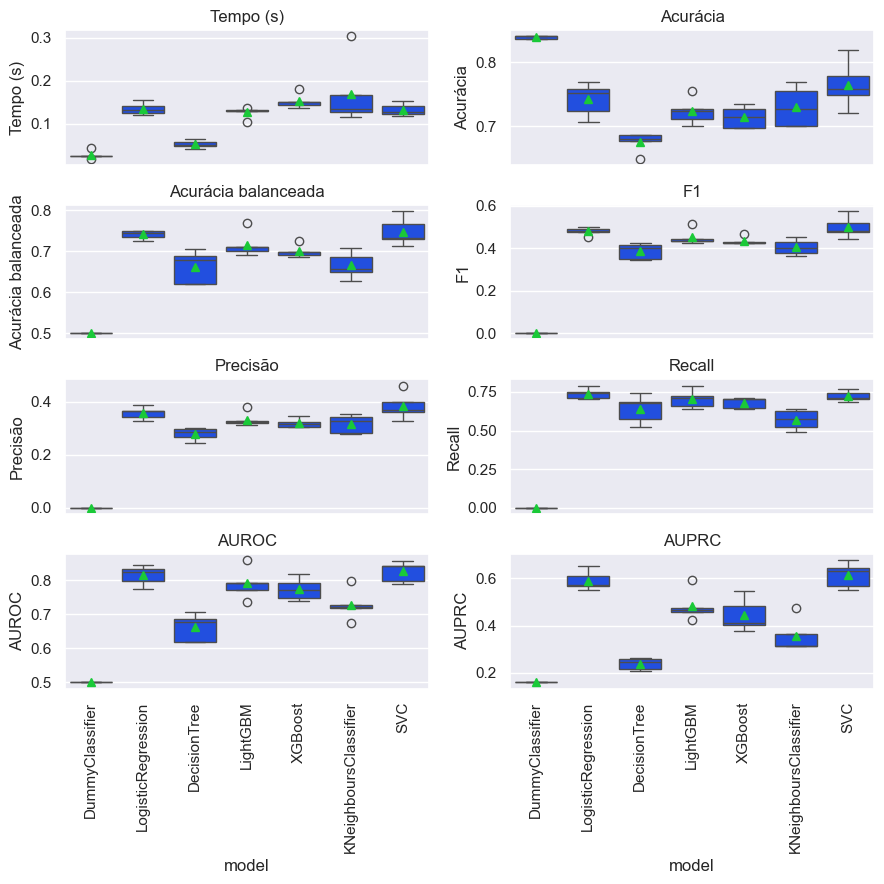

In [16]:
plot_comparar_metricas_modelos(df_resultados)

Veja que os melhores modelos continuam sendo o LogisticRegression e o SVC, com uma ligeira vantagem pro SVC agora com o RandomUnderSampler.

#### Escolher modelo para otimização: *LogisticRegression*
- Os melhores modelos foram LogisticRegression e SVC
- Mas o SVC é mais lento, possui interpretação mais complexa e recall menor quando comparado com LogisticRegression
- Podemos fazer um segundo grid_search usando o SVC para comparar os resultados dos 2 modelos otimizados caso acharmos necessário posteriormente.

#### Testando diferentes parâmetros no melhor modelo

In [17]:
param_grid = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', None],                # Regularização
    'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],                        # Apenas se o modelo for elastic_net
    'clf__C': [0.01, 0.1, 1, 10],    
    'clf__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    #'clf__class_weight': [None, 'balanced']                         # Podemos tirar do grid_search e já deixar dentro do modelo, será uma variável a menos pra ser analisada
}

#### Rodando a função do GridSearchCV

In [18]:
clf = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

grid_search = grid_search_cv_classificador(
    clf,
    param_grid=param_grid,
    cv=kf,
    preprocessor=preprocessamento,
    refit_metric='average_precision'
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [19]:
grid_search.fit(X,y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
600 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brcprrcchave\AppData\Local\anaconda

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [20]:
grid_search.best_score_            

0.617177404865779

**Análise do best_score_**: Aumentou de 0.58 no modelo simples do LogisticRegression para 0.61. 
- Com o class_weight='balanced' e sem RandomUnderSampler o resultado foi de 0.634, podemos testar outras métricas de balanceameto de classe.

In [21]:
grid_search.best_params_

{'clf__C': 0.1,
 'clf__l1_ratio': 0,
 'clf__penalty': 'l2',
 'clf__solver': 'saga'}

**OBS:** Veja que tivemos penalty='elasticnet' indicando que houve sim regularização do modelo, ou seja, algumas features do modelo tiveram seu coeficiente zerado.

#### Obtendo as Outras Métricas do grid_search.best_estimator

In [22]:
metricas_grid_search(grid_search)

mean_fit_time: 0.2791131496429443
mean_score_time: 0.11718583106994629
mean_test_accuracy: 0.7435374149659865
mean_test_balanced_accuracy: 0.744976620501195
mean_test_f1: 0.48442577102574286
mean_test_precision: 0.3587984222680607
mean_test_recall: 0.7470744680851065
mean_test_roc_auc: 0.8197452620630521
mean_test_average_precision: 0.617177404865779


#### Analisando coeficientes das features de maior importância pro modelo

In [23]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
ordinal__JobInvolvement,-0.501825
power_transform__MonthlyIncome,-0.384852
one_hot__EducationField_Life Sciences,-0.300933
power_transform__TotalWorkingYears,-0.257378
one_hot__Department_Research & Development,-0.232587
power_transform__YearsWithCurrManager,-0.228642
ordinal__RelationshipSatisfaction,-0.226784
power_transform__YearsInCurrentRole,-0.216822
ordinal__StockOptionLevel,-0.213345
power_transform__TrainingTimesLastYear,-0.204737


- Como um dos melhores parametros para esse modelo de LogisticRegression foi o l1_ratio=0, a regularização das features reduzindo a importância do coeficiente de algumas features, mas sem anular por completo nenhum coeficiente.
- Posso voltar pra análise exploratória pra deixar o projeto mais detalhado, já sabendo quais features que não devo me preocupar em maior detalhamento, pois não influencia o Attrition.

In [24]:
coefs.query('coeficiente == 0')

,coeficiente


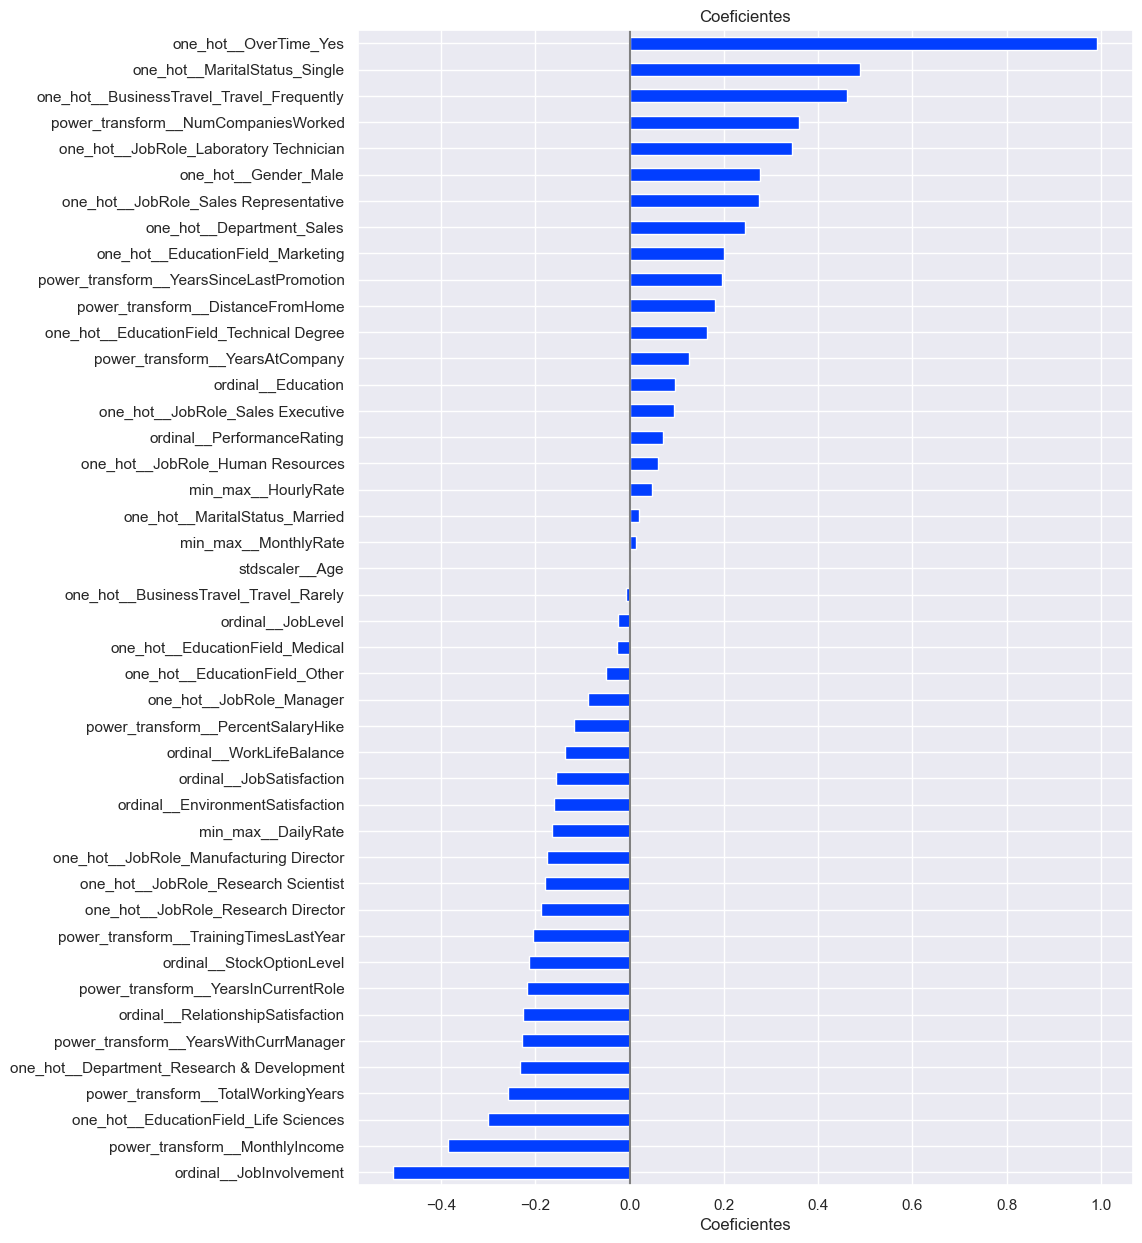

In [25]:
plot_coeficientes(coefs.query('coeficiente !=0'))

**Observações - Correlação não explica causalidade**

- Por exemplo, temos um maior % de Attrition em "solteiros", mas o fato de ser solteiro não quer dizer que as pessoas vão sair da empresa (só que talvez os casados tenham menor probabilidade pois existe a suposição de que podem ter família pra cuidar).

- Podemos destacar sim que Horas Extras e Viagem Frequente tem maior correlação (e não causalidade) com o Attrition.


#### <font color = 'darkblue'> **Transformando os coeficientes de uma regressão logística numa Probabilidade da feature influenciar o target**

##### **Explicação dos Coeficientes de uma Regressão Logística**

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$, variável contínua):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$, variável categórica):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


In [26]:
coefs_odds = coefs.copy()

coefs_odds['coeficiente'] = np.exp(coefs_odds['coeficiente'])

coefs_odds

,coeficiente
ordinal__JobInvolvement,0.605425
power_transform__MonthlyIncome,0.680551
one_hot__EducationField_Life Sciences,0.740127
power_transform__TotalWorkingYears,0.773076
one_hot__Department_Research & Development,0.792481
power_transform__YearsWithCurrManager,0.795613
ordinal__RelationshipSatisfaction,0.797093
power_transform__YearsInCurrentRole,0.805073
ordinal__StockOptionLevel,0.807877
power_transform__TrainingTimesLastYear,0.814861


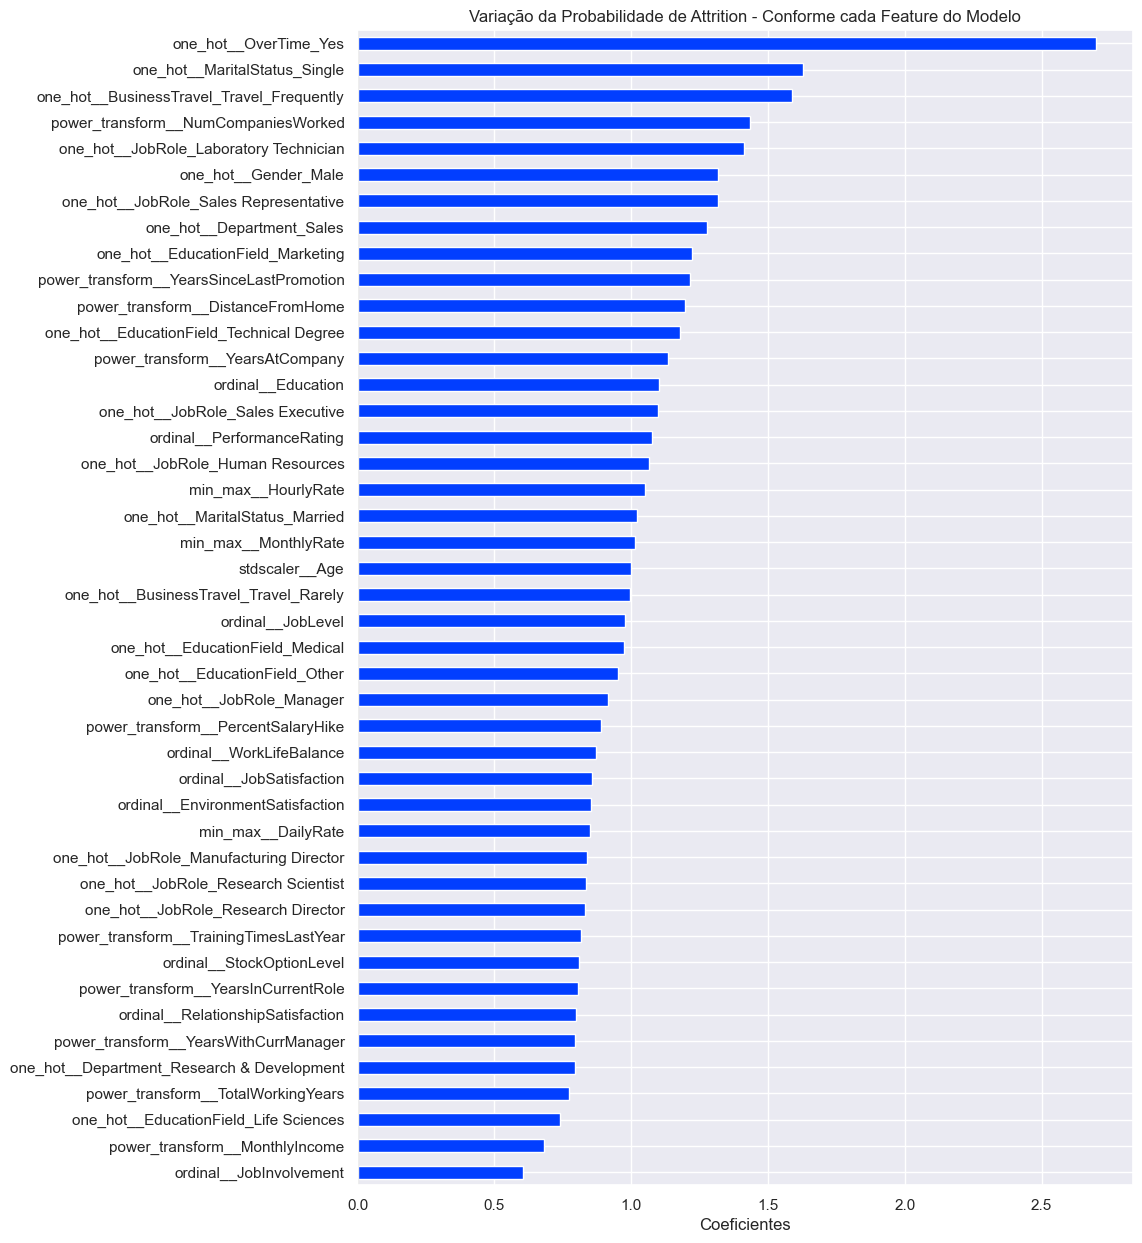

In [27]:
plot_coeficientes(
    coefs_odds.query('coeficiente != 1'),
    "Variação da Probabilidade de Attrition - Conforme cada Feature do Modelo"
)

##### **Conclusões**
- Podemos ver que os funcionários que fazem hora extra tem 2.7 vezes mais chances de deixar a empresa
- Funcionários que fazem viagens a trabalho tem 1.6 vezes mais chances de deixar a empresa também.
- Funcionários que são solteiros tendem a ter maior probabilidade de sair da empresa quando comparado com funcionários casados (correlação não indica causalidade nesse caso, é só um dado observado)
- Já features relacionadas à satisfação e envolvimento do funcionário na empresa / cargo ajudam a manter os funcionários, assim como o maior renda mensal e a quantidade de anos trabalhando na empresa / cargo.

- *Houve pequenas mudanças no coeficiente % das features mudando de "class_weight='balanced'" para um método de RandomUnderSampler, mas nada tão significativo. As principais features continuam sendo as mesmas.*

#### Matriz de Confusão

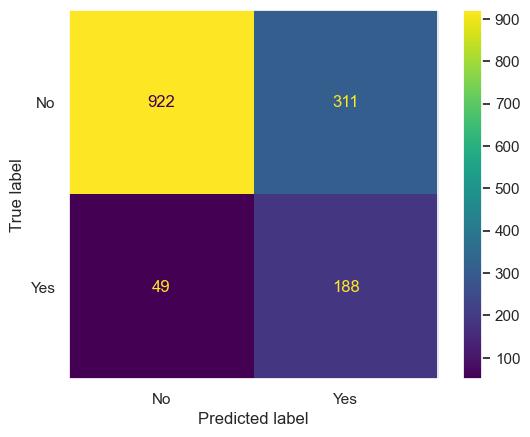

In [28]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_
)

plt.grid(False)
plt.show()

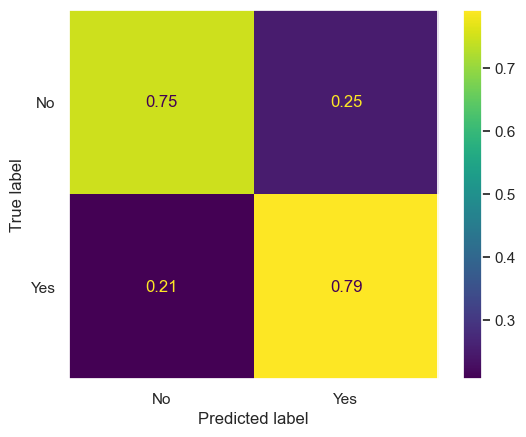

In [29]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_,
    normalize='true'
)

plt.grid(False)
plt.show()

#### Explicando como obter a probabilidade do funcionário sair da empresa

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = RANDOM_STATE, stratify=y
)

grid_search.best_estimator_.fit(X_train, y_train)

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0,
                                    random_state=42, solver='saga'))])

In [31]:
y_pred = grid_search.best_estimator_.predict(X_test)

y_pred[:10]              # É o predict com as classes 0 e 1

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [32]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)

y_pred_proba[:10]        # É o predict com as probabilidades de pertencer às classes 0 e 1

array([[0.34521585, 0.65478415],
       [0.92994419, 0.07005581],
       [0.64021609, 0.35978391],
       [0.95551931, 0.04448069],
       [0.43278386, 0.56721614],
       [0.53631537, 0.46368463],
       [0.87326093, 0.12673907],
       [0.72990912, 0.27009088],
       [0.91073799, 0.08926201],
       [0.26392052, 0.73607948]])

A probabilidade do funcionário sair da empresa vai ser sempre o segundo valor da lista acima. É esse valor que vamos mostrar no Streamlit que receberá o modelo (probabilidade de saída do funcionário da empresa - Attrition).

#### **Exportando o modelo**
- FUNÇÃO: dump(modelo, "diretório_windows")

In [33]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\brcprrcchave\\OneDrive - Blount\\Documents\\Treinamentos & Cursos\\Ciência dos Dados Impressionador - Hashtag\\Mod 22 - Projeto - IBM Attrition\\modelos\\logistic_regression_rus.joblib']

#### **Plano de Ação**

- Avaliar os motivos que levam os funcionários a fazerem hora extra que podem influenciar no Attrition
    - Mão de obra insuficiente
    - Falta de organização institucional
    - Falta de treinamento
    - Necessidade de investimento em tecnologia
- Existe a possibilidade de diminuir ou limitar as viagens de negócios?
    - Como isso pode afetar alguns departamentos (ex: vendas)?
    - O que pode tornar as viagens de negócio um motivo para saída da empresa?
- Como a renda mensal de cada setor em nível da empresa se compara ao mercado?
- Quais as ações a empresa pode promover para aumentar o envolvimento e a satisfação do funcionários? Principalmente nos departamentos com maior probabilidade de Attrition 

**OBS**: Analisar as features que mais influenciam o modelo. Destacar features com relação positivas e negativas no estudo feito, ou pro resultado do projeto.

**GITHUB**: Destacar esse plano de ação no GitHub, sintetizando informações importantes do modelo e propondo ações, em algum arquivo / relatório como README, Conclusões, Plano_acao.txt, ou até numa apresentação de PowerPoint do projeto.